# Installation

In [2]:
%load_ext autoreload

In [3]:
%pip uninstall -y tempo_embeddings
%pip install -e ..

Found existing installation: tempo_embeddings 0.0.1
Uninstalling tempo_embeddings-0.0.1:
  Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=9609 sha256=b861416fd210a50fe9f165b050d51ce78758229c44dcce163b29f94d5542186e
  Stored in directory: /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-ephem-wheel-cache-yo3jkjl9/wheels/9d/dd/1c/d0e8ab6bde11a84556c00bd645333aaad0b90e2c38e11b0ed1
Successfully built tempo_embeddings
Note: you may need to r

In [4]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


# Initialize Database

In [5]:
from ipywidgets import widgets

host_selector = widgets.Dropdown(
    options=[("local", "localhost"), ("Research Cloud", "145.38.192.173")],
    value="145.38.192.173",
    description="DB Server:",
)
host_selector

Dropdown(description='DB Server:', index=1, options=(('local', 'localhost'), ('Research Cloud', '145.38.192.17…

In [6]:
%autoreload now

In [7]:
import weaviate
from tempo_embeddings.embeddings.model import SentenceTransformerModelWrapper
from tempo_embeddings.embeddings.weaviate_database import WeaviateDatabaseManager
from tempo_embeddings.settings import DEFAULT_LANGUAGE_MODEL

db = WeaviateDatabaseManager(
    client=weaviate.connect_to_local(host=host_selector.value, port=8087),
    model=SentenceTransformerModelWrapper.from_pretrained(DEFAULT_LANGUAGE_MODEL),
)

ERROR:root:No corpus directory found in [PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris'), PosixPath('/Users/carstenschnober/SEED_DATA/SemanticsSustainability'), PosixPath('/data/datasets/research-semantics-of-sustainability/semantics-of-sustainability/data'), PosixPath('/home/cschnober/data'), PosixPath('/Volumes/i-lab.data.uu.nl/research-semantics-of-sustainability/semantics-of-sustainability/data')]
/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group


# Search

In [8]:
from ipywidgets import widgets

collection_selector = widgets.SelectMultiple(
    options=list(db.get_available_collections()),
    value=["Telegraaf", "Volkskrant", "NRC", "Trouw", "AlgemeenDagblad"],
    description="Choose a Collection:",
    disabled=False,
    style={"description_width": "initial"},
)
collection_selector

SelectMultiple(description='Choose a Collection:', index=(4, 6, 0, 1, 2), options=('NRC', 'Trouw', 'AlgemeenDa…

In [9]:
text_widget = widgets.Text(
    placeholder="Enter a term", description="Search Term:", disabled=False
)
text_widget

Text(value='', description='Search Term:', placeholder='Enter a term')

In [10]:
field = "genre"

genres: set[str] = {
    value
    for collection in collection_selector.value
    for value in db.get_metadata_values(collection, field)
}

exclude_genres = widgets.SelectMultiple(
    options=genres, value=["advertentie"], description=f"Exclude {field}(s):"
)
exclude_genres

SelectMultiple(description='Exclude genre(s):', index=(1,), options=('illustratie met onderschrift', 'adverten…

In [11]:
metadata_not = {field: list(exclude_genres.value)}

# Plot Frequencies

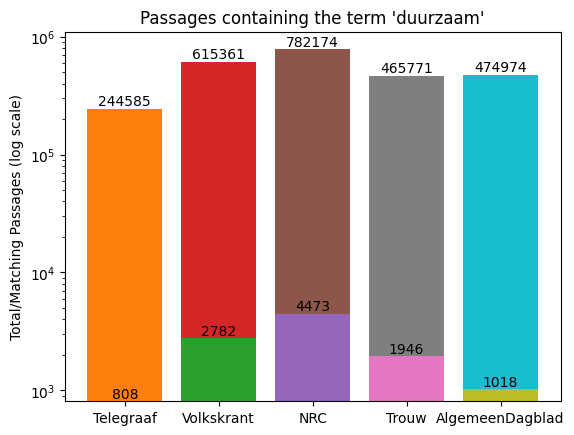

In [13]:
import matplotlib.pyplot as plt

assert text_widget.value.strip(), "No search term provided"

fig, ax = plt.subplots()

ax.set_title(f"Passages containing the term '{text_widget.value}'")

ax.set_ylabel("Total/Matching Passages (log scale)")
ax.set_yscale("log")

for collection in collection_selector.value:
    doc_freq = db.doc_frequency(
        text_widget.value, collection, metadata_not=metadata_not
    )
    total_count = db.doc_frequency("", collection, metadata_not=metadata_not)

    bar_matches = ax.bar(collection, doc_freq, label=f"{collection} - Matches")
    ax.bar_label(bar_matches, fmt="%d", label_type="edge")

    bar_total = ax.bar(
        collection,
        total_count - doc_freq,
        bottom=doc_freq,
        label=f"{collection} - Total",
    )
    ax.bar_label(bar_total, fmt="%d", label_type="edge")

# Frequencies Per Year

In [14]:
start = 1850
end = 2024

year_range = widgets.SelectionRangeSlider(
    options=[str(i) for i in range(start, end)],
    index=(100, 150),
    description="Years",
    disabled=False,
)
year_range

SelectionRangeSlider(description='Years', index=(100, 150), options=('1850', '1851', '1852', '1853', '1854', '…

In [15]:
import pandas as pd
from tqdm import tqdm

normalize = True

doc_freqs = pd.DataFrame(
    index=range(int(year_range.value[0]), int(year_range.value[1]))
)

for collection in tqdm(collection_selector.value, unit="collection"):
    doc_freqs[collection] = [
        db.doc_frequency(
            text_widget.value,
            collection,
            {"year": str(year)},
            metadata_not=metadata_not,
        )
        for year in doc_freqs.index
    ]

100%|██████████| 5/5 [00:01<00:00,  2.87collection/s]


<Axes: title={'center': "Absolute Frequency of 'duurzaam'"}, xlabel='Year', ylabel='Frequency'>

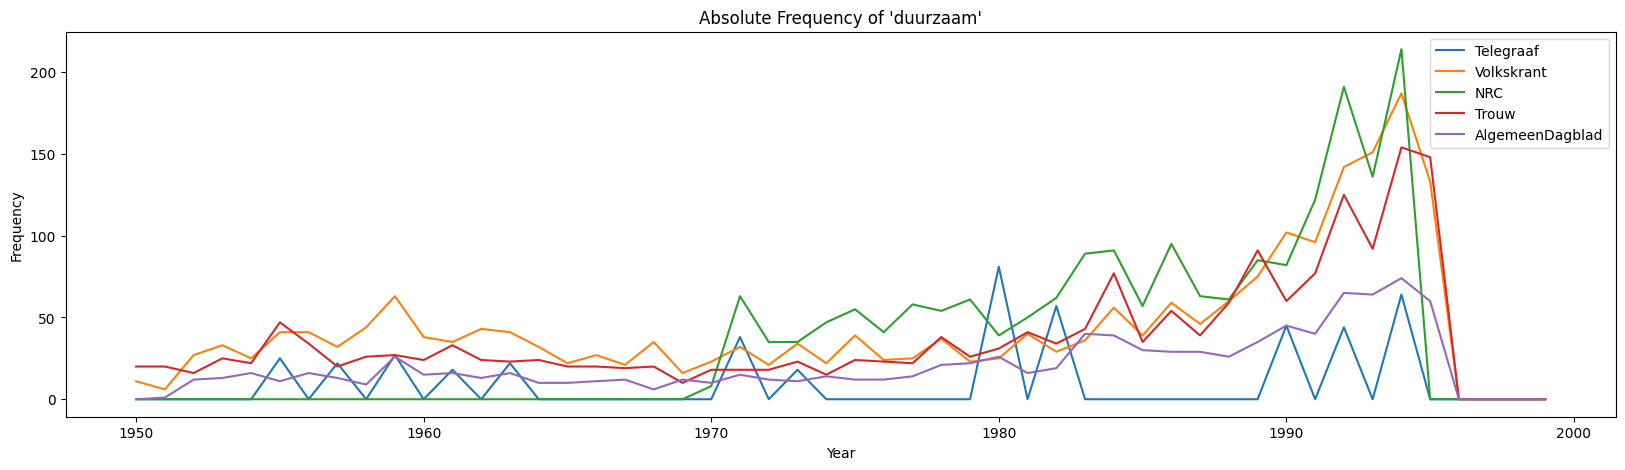

In [16]:
# TODO: interactive plot

doc_freqs.plot(
    figsize=(20, 5),
    title=f"Absolute Frequency of '{text_widget.value}'",
    xlabel="Year",
    ylabel="Frequency",
)

In [17]:
# Normalize counts

normalized = pd.DataFrame()

for collection in doc_freqs.columns:
    total_counts = [
        db.doc_frequency(
            "", collection, metadata={"year": str(year)}, metadata_not=metadata_not
        )
        for year in doc_freqs.index
    ]
    normalized[collection] = doc_freqs[collection] / total_counts

<Axes: title={'center': "Relative Frequency of 'duurzaam'"}, xlabel='Year', ylabel='Relative Frequency'>

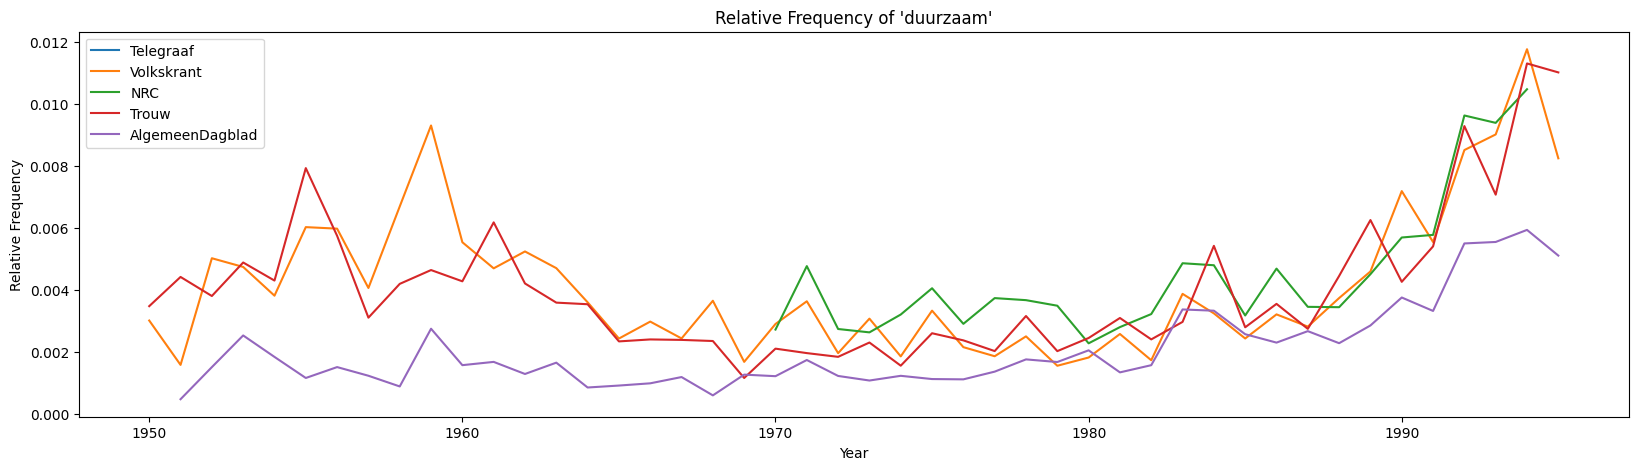

In [18]:
normalized.plot(
    figsize=(20, 5),
    title=f"Relative Frequency of '{text_widget.value}'",
    xlabel="Year",
    ylabel="Relative Frequency",
)

# Create Corpus

In [19]:
%autoreload now

In [20]:
collections = [
    db.get_corpus(
        collection,
        [text_widget.value],
        year_from=year_range.value[0],
        year_to=year_range.value[1],
        include_embeddings=True,
        metadata_not=metadata_not,
    )
    for collection in collection_selector.value
]

In [21]:
collections[0].passages[0]

Passage("Ze heeft het laatste gekozen en het verschil van de subsidie afgetrokken. ' -k Kr is een duurzaam arbeids• tekort in de landbouw en er worden in de agrarische sector t de laagste lonen van Nederland t betaald.", {'sentence_index': 3.0, 'year': '1955', 'newspaper': 'Telegraaf', 'date': '1955-01-12', 'provenance': 'Telegraaf_1955.csv.gz', 'recId': 'ddd:110585885:mpeg21:a0027', 'article_tit': 'Lonen 24 % hoger', 'genre': 'artikel'}, Highlighting(start=89, end=97))

In [22]:
# Expand each collection


for collection in tqdm(collections, unit="collection", desc="Expanding"):
    # Double the size of the collection
    neighbours = db.neighbour_passages(
        collection,
        k=len(collection),
        collections=collection_selector.value,
        metadata_not=metadata_not,
    )
    collection.extend(neighbours)

# TODO: allow expansion to other collections, requires metadata harmonisation (genre)

Expanding: 100%|██████████| 5/5 [00:22<00:00,  4.50s/collection]


In [23]:
from tempo_embeddings.text.corpus import Corpus

corpus = sum(collections, start=Corpus())

In [24]:
corpus.compress_embeddings(recompute=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


array([[ 5.4496174 ,  4.3777885 ],
       [ 3.7463715 ,  0.9029705 ],
       [ 4.530897  , -1.2651935 ],
       ...,
       [ 9.796592  , -0.60943824],
       [ 8.873334  ,  1.9628462 ],
       [ 9.472901  ,  2.8673797 ]], dtype=float32)

## Cluster Corpus

In [25]:
clusters = corpus.cluster(
    max_clusters=25,
    cluster_selection_method="eom",
    max_cluster_size=100,
    min_samples=10,
)

In [26]:
from tempo_embeddings.settings import STOPWORDS

for cluster in clusters:
    cluster.set_topic_label(exclude_words=STOPWORDS | {text_widget.value})

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [27]:
import os

from bokeh.io import output_notebook
from bokeh.plotting import show

from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer

try:
    del visualizer
except NameError:
    pass

visualizer = BokehInteractiveVisualizer(*clusters, width=1500, height=500)

os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "*"

output_notebook()

show(visualizer.create_document)

Loading BokehJS ...